In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from math import comb

plt_style = {"text.usetex": True,
             "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
             "axes.spines.right" : False,
             "axes.spines.top" : False,
             "font.size": 22,
             "savefig.dpi": 600,
             "savefig.bbox": 'tight'
            }

In this example, we look at a synthetic data that we generate using a normal distribution $\mathcal{N}(\mu, \sigma)$ where we set different mean values to sample data from a ground truth different mean model. Alternatively, we set all the $\mu$ values to be the same if we want it to be a single mean model.

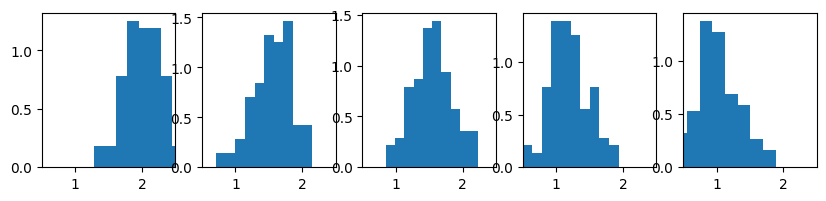

In [2]:
# Create dummy life time data for any battery
def sample_battery_lifetime(means, sizes, std=0.3):
    samples = []
    for mi, ni in zip(means, sizes):
        samples.append(np.random.normal(loc=mi, scale=std, size=ni))
        
    return samples

# generate seperate means data
yij = sample_battery_lifetime([2.0, 1.6, 1.5, 1.15, 1.0], [100, 100, 100, 100, 100])

# generate single mean data
# yij = sample_battery_lifetime([2.0, 2.0, 2.0, 2.0, 2.0], [100, 100, 100, 100, 100])


fig, axs = plt.subplots(1,5, figsize=(2*5, 2))
for i, yi in enumerate(yij):
    axs[i].hist(yi, density=True)
    axs[i].set_xlim([0.5, 2.5])
plt.show()

This histogram plot should tell us whether each level has a different mean or a the same mean

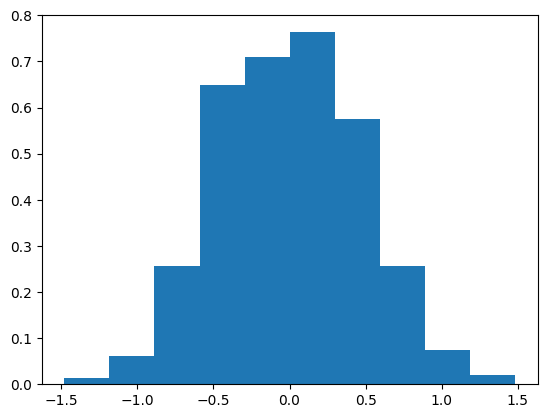

In [3]:
global_mean = np.hstack(yij).mean()

global_residuals = [y-global_mean for y in np.hstack(yij)]
plt.hist(global_residuals, density=True)
plt.show()

We can also visualize the residuals from the global mean to see that they roughly follow a normal distribution as we increase the number of samples because of central limit theorem

Next, let us compute the mean value of each level and call it `group_means` ($\bar{y}_{i,.}$) and the beta variation given by $$\beta_i = \bar{y}_{i,.} - \bar{y}_{., .}$$

In [4]:
group_means = np.zeros(len(yij))
betas = np.zeros(len(yij))
for i, yi in enumerate(yij):
    group_means[i] = np.mean(yi)
    betas[i] = group_means[i] - global_mean
    print('Mean of group %d  is %2.4f; Beta residual %2.4f'%(i, group_means[i], betas[i]))

Mean of group 0  is 2.0344; Beta residual 0.5627
Mean of group 1  is 1.5655; Beta residual 0.0938
Mean of group 2  is 1.5558; Beta residual 0.0841
Mean of group 3  is 1.1900; Beta residual -0.2817
Mean of group 4  is 1.0128; Beta residual -0.4589


We can now compute the required sum of squares :  $$ SS_{\text{total}} = \sum_{i}^{g}\sum_{j}^{n_{i}} y_{ij} - \bar{y}_{.,.}$$
$$ SS_{\text{level}} = \sum_{i}^{g}\sum_{j}^{n_{i}} \beta^{2}_{i} $$
$$ SS_{\text{error}} = \sum_{i}^{g}\sum_{j}^{n_{i}} e^{2}_{ij} $$

In [5]:
SS_total = np.sum([r**2 for r in global_residuals])
SS_level = np.sum([len(yi)*b**2 for yi,b in zip(yij,betas)])
SS_error = 0
for i, yi in enumerate(yij):
    for yj in yi:
        SS_error += (yj-group_means[i])**2

print('Total SS is %2.4f; \n Group level SS is %2.4f; \n Error SS is %2.4f'%(SS_total, SS_level, SS_error))

Total SS is 107.2345; 
 Group level SS is 62.2516; 
 Error SS is 44.9828


The f-statistic is given by $$f_{0} = \frac{SS_{\text{level}}/(g-1)}{SS_{\text{error}}/(N-g)}$$

In [6]:
g = len(yij)
N = sum([len(yi) for yi in yij])

f0 = (SS_level/(g-1))/(SS_error/(N-g))
print('F-statistic is %2.4f'%f0)

F-statistic is 171.2574


In [7]:
# scipy has this method implemented already
# recall that p-value measure the probability of observing the f0 value
# as extreme when the null hypothesis is True i.e. a single mean model
from scipy.stats import f_oneway
f_oneway(*yij)

F_onewayResult(statistic=171.25735593517572, pvalue=6.049416922056318e-92)